# Mod 4 Project - Starter Notebook

This notebook has been provided to you so that you can make use of the following starter code to help with the trickier parts of preprocessing the Zillow dataset. 

The notebook contains a rough outline the general order you'll likely want to take in this project. You'll notice that most of the areas are left blank. This is so that it's more obvious exactly when you should make use of the starter code provided for preprocessing. 

**_NOTE:_** The number of empty cells are not meant to infer how much or how little code should be involved in any given step--we've just provided a few for your convenience. Add, delete, and change things around in this notebook as needed!

# Some Notes Before Starting

This project will be one of the more challenging projects you complete in this program. This is because working with Time Series data is a bit different than working with regular datasets. In order to make this a bit less frustrating and help you understand what you need to do (and when you need to do it), we'll quickly review the dataset formats that you'll encounter in this project. 

## Wide Format vs Long Format

If you take a look at the format of the data in `zillow_data.csv`, you'll notice that the actual Time Series values are stored as separate columns. Here's a sample: 

<img src='~/../images/df_head.png'>

You'll notice that the first seven columns look like any other dataset you're used to working with. However, column 8 refers to the median housing sales values for April 1996, column 9 for May 1996, and so on. This This is called **_Wide Format_**, and it makes the dataframe intuitive and easy to read. However, there are problems with this format when it comes to actually learning from the data, because the data only makes sense if you know the name of the column that the data can be found it. Since column names are metadata, our algorithms will miss out on what dates each value is for. This means that before we pass this data to our ARIMA model, we'll need to reshape our dataset to **_Long Format_**. Reshaped into long format, the dataframe above would now look like:

<img src='~/../images/melted1.png'>

There are now many more rows in this dataset--one for each unique time and zipcode combination in the data! Once our dataset is in this format, we'll be able to train an ARIMA model on it. The method used to convert from Wide to Long is `pd.melt()`, and it is common to refer to our dataset as 'melted' after the transition to denote that it is in long format. 

# Helper Functions Provided

Melting a dataset can be tricky if you've never done it before, so you'll see that we have provided a sample function, `melt_data()`, to help you with this step below. Also provided is:

* `get_datetimes()`, a function to deal with converting the column values for datetimes as a pandas series of datetime objects
* Some good parameters for matplotlib to help make your visualizations more readable. 

Good luck!


# Step 1: Load the Data/Filtering for Chosen Zipcodes

In [83]:
# Import necessary libraries
import warnings
warnings.filterwarnings('ignore')
import itertools
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams

In [1]:
import pandas as pd
%matplotlib inline
df = pd.DataFrame(pd.read_csv('zillow_data.csv'))
df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


In [2]:
df.dtypes

RegionID        int64
RegionName      int64
City           object
State          object
Metro          object
CountyName     object
SizeRank        int64
1996-04       float64
1996-05       float64
1996-06       float64
1996-07       float64
1996-08       float64
1996-09       float64
1996-10       float64
1996-11       float64
1996-12       float64
1997-01       float64
1997-02       float64
1997-03       float64
1997-04       float64
1997-05       float64
1997-06       float64
1997-07       float64
1997-08       float64
1997-09       float64
1997-10       float64
1997-11       float64
1997-12       float64
1998-01       float64
1998-02       float64
               ...   
2015-11         int64
2015-12         int64
2016-01         int64
2016-02         int64
2016-03         int64
2016-04         int64
2016-05         int64
2016-06         int64
2016-07         int64
2016-08         int64
2016-09         int64
2016-10         int64
2016-11         int64
2016-12         int64
2017-01   

In [109]:
df.shape

(14723, 272)

# Step 2: Data Preprocessing

In [3]:
df.columns

Index(['RegionID', 'RegionName', 'City', 'State', 'Metro', 'CountyName',
       'SizeRank', '1996-04', '1996-05', '1996-06',
       ...
       '2017-07', '2017-08', '2017-09', '2017-10', '2017-11', '2017-12',
       '2018-01', '2018-02', '2018-03', '2018-04'],
      dtype='object', length=272)

In [2]:
def get_datetimes(df):
    return pd.to_datetime(df.columns.values[7:], format='%Y-%m')

In [6]:
get_datetimes(df)

AttributeError: 'DatetimeIndex' object has no attribute 'columns'

# Step 3: Reshape from Wide to Long Format

In [3]:
def melt_data(df):
    melted = pd.melt(df, id_vars=['RegionID','RegionName', 'City', 'State', 'Metro', 'CountyName', 'SizeRank'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    return melted.groupby('time').aggregate({'value':'mean'})

In [4]:
df_melt_data = melt_data(df)

In [5]:
get_datetimes(df_melt_data)

DatetimeIndex([], dtype='datetime64[ns]', freq=None)

In [6]:
df_melt_data['difference'] = df_melt_data.diff()

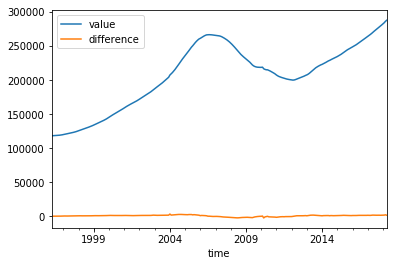

In [7]:
df_melt_data.plot()

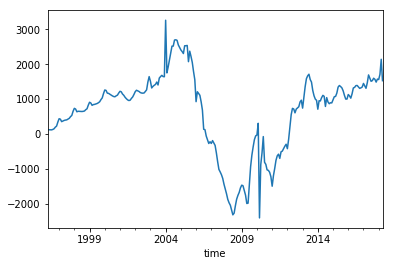

In [16]:
df_melt_data['difference'].plot()

In [17]:
df_melt_data['difference2'] = df_melt_data.difference.diff()
df_melt_data

,value,difference,difference2
time,,,
1996-04-01,118299.123063,NaN,NaN
1996-05-01,118419.044139,119.921076,NaN
1996-06-01,118537.423268,118.379129,-1.541947
1996-07-01,118653.069278,115.646010,-2.733119
1996-08-01,118780.254312,127.185034,11.539024
1996-09-01,118927.528500,147.274189,20.089155
1996-10-01,119120.520316,192.991815,45.717626
1996-11-01,119345.352236,224.831920,31.840105
1996-12-01,119685.084771,339.732534,114.900614


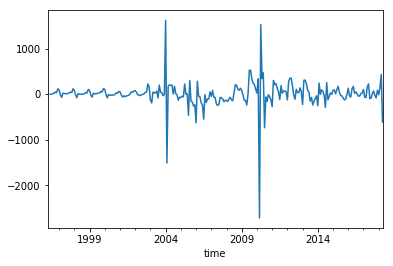

In [18]:
df_melt_data['difference2'].plot()

In [36]:
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from matplotlib.pylab import rcParams
import matplotlib.pyplot as plt

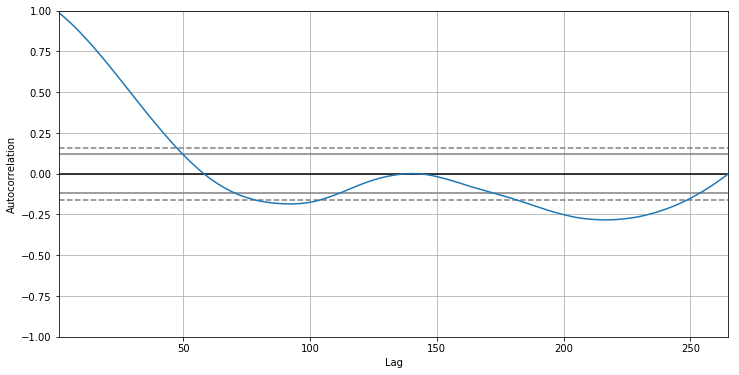

In [35]:
plt.figure(figsize=(12,6))
pd.plotting.autocorrelation_plot(df_melt_data['value'])

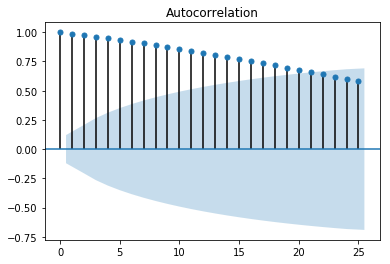

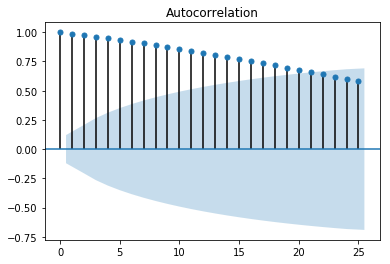

In [73]:
plot_acf(df_melt_data['value'], lags = 25)

In [32]:
from statsmodels.tsa.stattools import adfuller
X = df_melt_data['value'].values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -1.885145
p-value: 0.339082
Critical Values:
	1%: -3.456
	5%: -2.873
	10%: -2.573


In [30]:
from statsmodels.tsa.stattools import adfuller
X = df_melt_data['difference'].values[1:]
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.548782
p-value: 0.104052
Critical Values:
	1%: -3.457
	5%: -2.873
	10%: -2.573


In [31]:
from statsmodels.tsa.stattools import adfuller
X = df_melt_data['difference2'].values[2:]
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -21.111269
p-value: 0.000000
Critical Values:
	1%: -3.456
	5%: -2.873
	10%: -2.573


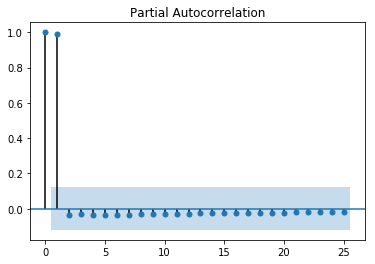

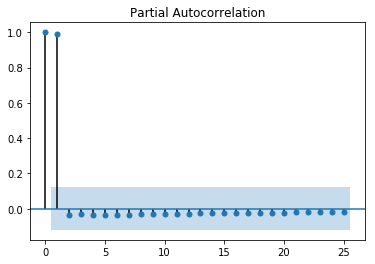

In [34]:
plot_pacf(df_melt_data['value'])

In [74]:
from statsmodels.tsa.arima_model import ARIMA
#fit ARIMA model (3,1,0))
model = ARIMA(df_melt_data.value, order=(20,2,2))
model_fit = model.fit(disp=0)
print(model_fit.summary())

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:               D2.value   No. Observations:                  263
Model:                ARIMA(20, 2, 2)   Log Likelihood               -1836.661
Method:                       css-mle   S.D. of innovations            260.343
Date:                Fri, 26 Jul 2019   AIC                           3721.322
Time:                        11:58:21   BIC                           3807.054
Sample:                    06-01-1996   HQIC                          3755.775
                         - 04-01-2018                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               6.2087     16.874      0.368      0.713     -26.864      39.281
ar.L1.D2.value      0.5402      0.116      4.662      0.000       0.313       0.767
ar.L2.D2.value     -0.7123      

In [77]:
from statsmodels.tsa.arima_model import ARIMA
#fit ARIMA model (3,1,0))
model = ARIMA(df_melt_data.value, order=(1,2,0))
model_fit = model.fit(disp=0)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:               D2.value   No. Observations:                  263
Model:                 ARIMA(1, 2, 0)   Log Likelihood               -1850.266
Method:                       css-mle   S.D. of innovations            274.829
Date:                Fri, 26 Jul 2019   AIC                           3706.532
Time:                        13:25:47   BIC                           3717.249
Sample:                    06-01-1996   HQIC                          3710.839
                         - 04-01-2018                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              5.8663     13.343      0.440      0.661     -20.285      32.018
ar.L1.D2.value    -0.2712      0.060     -4.536      0.000      -0.388      -0.154
                                    

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


In [79]:
model_fit.plot_diagnostics()

AttributeError: 'ARIMAResults' object has no attribute 'plot_diagnostics'

In [91]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 3)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
pdqs = [(x[0], x[1], x[2], y) for x in list(itertools.product(p, d, q))]

In [92]:
ans = []
for comb in pdq:
    for combs in pdqs:
        try:
            mod = sm.tsa.statespace.SARIMAX(df_melt_data.value,
                                            order=comb,
                                            seasonal_order=combs,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            output = mod.fit()
            ans.append([comb, combs, output.aic])
            print('ARIMA {} x {}12 : AIC Calculated ={}'.format(comb, combs, output.aic))
        except:
            continue

ARIMA (0, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated =7227.7079129085505
ARIMA (0, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated =6742.95190659201
ARIMA (0, 0, 0) x (0, 0, 2, 12)12 : AIC Calculated =10813.604196415818
ARIMA (0, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated =5572.264748163526
ARIMA (0, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated =5316.092266974734
ARIMA (0, 0, 0) x (0, 1, 2, 12)12 : AIC Calculated =4800.494711093052
ARIMA (0, 0, 0) x (0, 2, 0, 12)12 : AIC Calculated =5034.520292642388
ARIMA (0, 0, 0) x (0, 2, 1, 12)12 : AIC Calculated =4774.338798452531
ARIMA (0, 0, 0) x (0, 2, 2, 12)12 : AIC Calculated =4501.533934273119
ARIMA (0, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated =5540.959630400202
ARIMA (0, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated =5491.481015453017
ARIMA (0, 0, 0) x (1, 0, 2, 12)12 : AIC Calculated =5022.874462006483
ARIMA (0, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated =5042.996371372234
ARIMA (0, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated =6618.038615940865
ARIMA (0, 0, 0) x (

In [108]:
%%timeit
model_ = sm.tsa.statespace.SARIMAX(df_melt_data.value,
                                            order=(1,2,2),
                                            seasonal_order=(2,2,2,12),
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
work = model_.fit()

5.56 s ± 99.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [107]:
print(work.summary())

                                 Statespace Model Results                                 
Dep. Variable:                              value   No. Observations:                  265
Model:             SARIMAX(1, 2, 2)x(2, 2, 2, 12)   Log Likelihood               -1548.023
Date:                            Fri, 26 Jul 2019   AIC                           3112.045
Time:                                    14:07:07   BIC                           3138.898
Sample:                                04-01-1996   HQIC                          3122.898
                                     - 04-01-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3455      0.097     -3.547      0.000      -0.536      -0.155
ma.L1          0.0984      0.100   

In [103]:
min(ans, key = lambda x: x[2])

[(1, 2, 2), (2, 2, 2, 12), 3112.045024782751]

# Step 4: EDA and Visualization
Perform basic EDA as you would building any model, then create at least 3 visualizations.  At least one of the visualizations should have time on the x-axis.  Axes should be labeled and any text should be legible.

In [ ]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}

matplotlib.rc('font', **font)

# NOTE: if you visualizations are too cluttered to read, try calling 'plt.gcf().autofmt_xdate()'!

# Step 5: ARIMA Modeling
Be sure to validate your model.  Make a forecast for the future and describe the trend.

# Step 6: Interpreting Results
Give a detailed interpretation of results including the relationship between the inputs and output of the model.